In [249]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

In [250]:

# Database connection parameters
db_params = {
    'dbname': 'integration',
    'user': 'postgres',
    'password': '1234',
    'host': 'localhost',
    'port': '5432'
}


In [251]:
# Establishing the connection
conn = psycopg2.connect(**db_params)

# Define your SQL query
query = "SELECT * FROM db_events;"

# Execute the query and store the result in a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Display the DataFrame
print(df.head())

C:\Users\Zephyrus\AppData\Local\Temp\ipykernel_22344\3958174467.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


   duracion       fecha  hora  esquema                tabla  \
0        38  2024-06-01     0  sat_fel  p_dte_emisor_gtq_ag   
1        42  2024-06-01     0  sat_fel  p_dte_emisor_gtq_ag   
2        27  2024-06-01     0  sat_fel  p_dte_emisor_gtq_ag   
3        15  2024-06-01     0  sat_fel  p_dte_emisor_gtq_ag   
4        21  2024-06-01     0  sat_fel  p_dte_emisor_gtq_ag   

                                    app  Day of month  ID Day of week  \
0  2ff814a6-3304-4ab8-85cb-cd0e6f879c1d             1               7   
1  2ff814a6-3304-4ab8-85cb-cd0e6f879c1d             1               7   
2  2ff814a6-3304-4ab8-85cb-cd0e6f879c1d             1               7   
3  2ff814a6-3304-4ab8-85cb-cd0e6f879c1d             1               7   
4  2ff814a6-3304-4ab8-85cb-cd0e6f879c1d             1               7   

  Day of week    mean_st  ...  rango_final_by_table  tamañano_resp_by_table  \
0      sábado  28.165406  ...          7.980910e+07            2.439692e+06   
1      sábado  28.165406

In [252]:
df.columns

Index(['duracion', 'fecha', 'hora', 'esquema', 'tabla', 'app', 'Day of month',
       'ID Day of week', 'Day of week', 'mean_st', 'std_st', 'min', 'max',
       'rango_inicial_by_table', 'rango_final_by_table',
       'tamañano_resp_by_table', 'min_boundary', 'b_ound', 'Periodo Del Mes',
       'Evento del Dia', 'pre_clasificacion', 'latencia_by_day_month',
       'latencia_by_day_week', 'SimultJobs'],
      dtype='object')

In [253]:
d_row = df[df['pre_clasificacion'] == 'NORMAL']

# Randomly select 50% of those rows
np.random.seed(0)  # For reproducibility
sample_rows_d = d_row.sample(frac=0.64) #0.7

# Drop the selected rows from the original DataFrame
df = df.drop(sample_rows_d.index)

In [254]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

selected_cols = df[[ 'tabla','app','Day of month','ID Day of week', 'min', 'max',
       'rango_inicial_by_table', 'rango_final_by_table',
       'tamañano_resp_by_table'
       ,'Evento del Dia','SimultJobs','latencia_by_day_month',
       'latencia_by_day_week','pre_clasificacion']]

categorical_columns = ['tabla', 'Evento del Dia','app']
numeric_columns = ['ID Day of week','min','max','SimultJobs','Day of month','rango_inicial_by_table','rango_final_by_table'
                   ,'tamañano_resp_by_table','latencia_by_day_month','latencia_by_day_week']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_columns),
        ('num', 'passthrough', numeric_columns)
    ])


encoded_data = preprocessor.fit_transform(selected_cols)

X = encoded_data
y = selected_cols['pre_clasificacion']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [255]:
from collections import Counter
# Get the frequency of elements in the list
frequency = Counter(y_train)
# Print the frequency
print(frequency)

Counter({'NORMAL': 629477, 'TARDADO': 623693})


In [256]:
from collections import Counter
# Get the frequency of elements in the list
frequency = Counter(y_test)
# Print the frequency
print(frequency)

Counter({'NORMAL': 269776, 'TARDADO': 267298})


In [257]:
# Classificador de bayes
nb = DecisionTreeClassifier()
nb.fit(X_train, y_train)

# Make predictions
y_pred = nb.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 67.56%


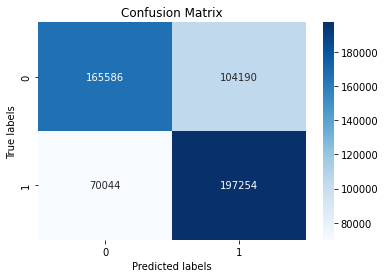

In [258]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [259]:
importances = nb.feature_importances_

# Print feature importances
for feature, importance in zip(selected_cols.columns, importances):
    print(f"{feature}: {importance}")

tabla: 0.0254793636619088
app: 0.007271925999987189
Day of month: 0.31111483860425526
ID Day of week: 0.013666258586795533
min: 0.006419303798174294
max: 0.05474874222947953
rango_inicial_by_table: 0.06512845045681682
rango_final_by_table: 0.05079960982279815
tamañano_resp_by_table: 0.011523595370861771
Evento del Dia: 0.010370482777515682
SimultJobs: 0.04504617195566402
latencia_by_day_month: 0.35593930056210704
latencia_by_day_week: 0.042491956173635936
